##### Comparison of rescaling on microscopy data from Diel et al. Nat. Protocols 2020 
###### Data in this notebook corresponds to Fig 5a in their paper.

###### First, load packages and functions:

In [1]:
import psf_extra as psfe
import numpy as np
import matplotlib.pyplot as plt

from utils import *

###### Load stacks:

In [2]:
#load stacks
location = 'D:\\axial_scaling\\data_dieletal\\OneDrive_1_9-20-2023\\' #location of stacks
gt_stack = psfe.load_stack(location+'tdtom_sx621_m1_sld2_slc3_whitematter_25x_1zoom_xyoptimal170_z103_s.tif')
distorted_stack = psfe.load_stack(location+'tdtom_sx621_m1_sld2_slc3_whitematter_20x_12zoom_xyoptimal170_zoptimal103_s.tif')

#invert z direction:
gt_stack = gt_stack[::-1, :, :]
distorted_stack = distorted_stack[::-1, :, :]

print('Done!')

Done!


###### Define parameters of stacks:

In [3]:
#define some parameters
ps_xy_gt = 0.1693581 # um
ps_z_gt = 1.0300000 # um

ps_xy_distorted = 0.1692507 # um
ps_z_distorted = 1.0269321 # um

n_im = 1.0
n_sample = 1.46
NA = 0.8
lam_0 = 0.58 # wavelength (microns)

shape_gt = np.shape(gt_stack)
shape_distorted = np.shape(distorted_stack)

###### Plot maximum intensity projections of the two stacks:

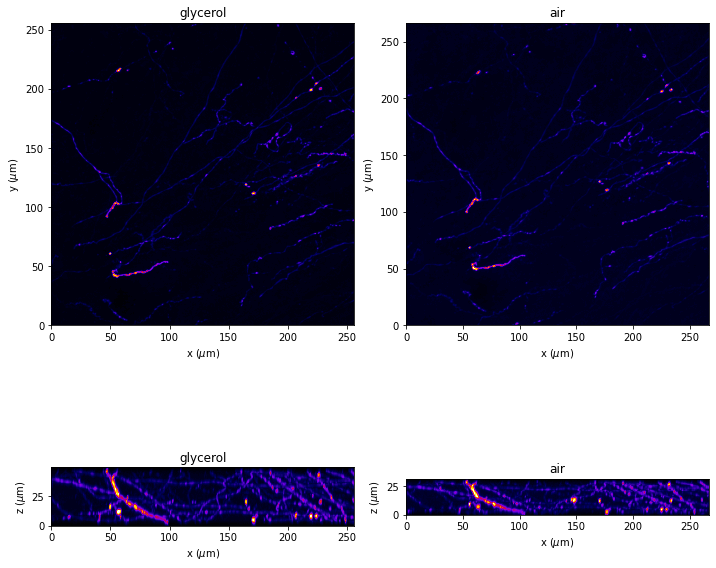

In [4]:
plot_stacks_MIPs(gt_stack,distorted_stack,['glycerol','air'], ['xy','xz'], ps_xy_gt, ps_z_gt, ps_xy_distorted, ps_z_distorted)

###### Rescale data using depth-dependent scaling:

In [5]:
stack_rescaled, afp_new_stack, afp_stack, nfp_stack = rescale_stack(distorted_stack[::-1], NA, n_im, n_sample, lam_0, ps_z_gt)

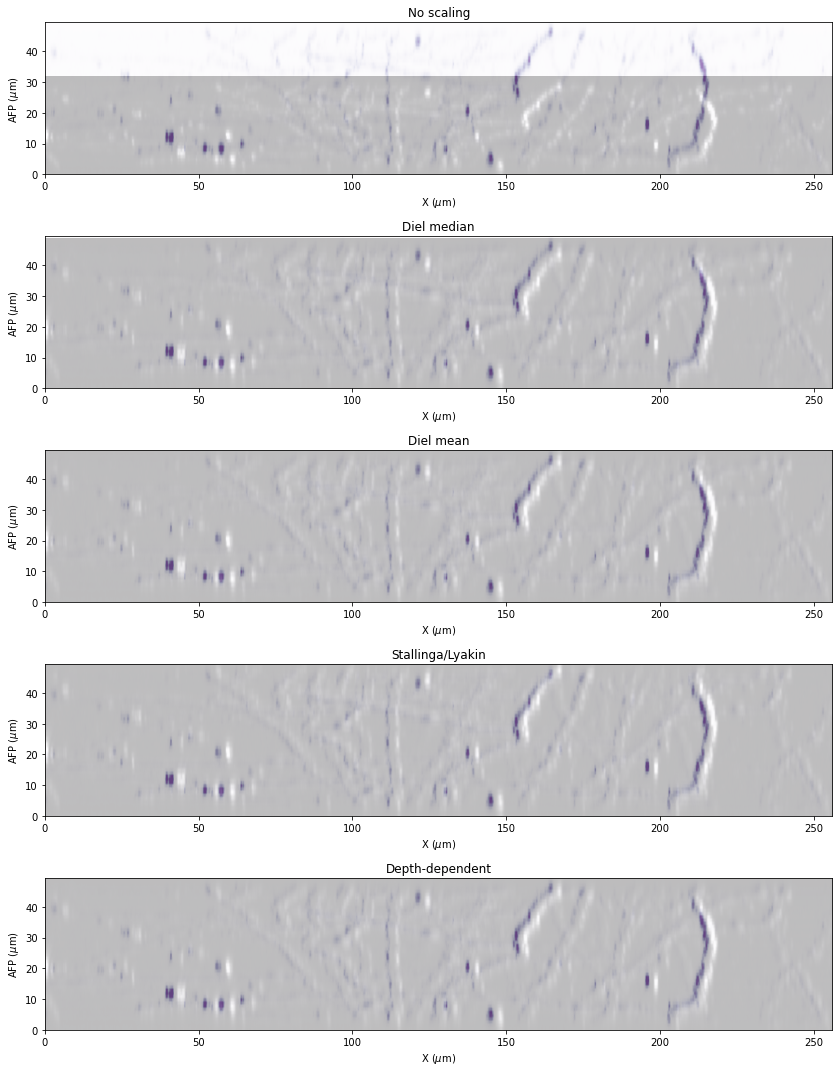

In [6]:
ps_z_distorted_diel_median = ps_z_distorted * diel_median([1],n_im,n_sample,NA)[0]
if n_sample > NA: ps_z_distorted_diel_mean = ps_z_distorted * diel_mean([1],n_im,n_sample,NA)[0]
else: ps_z_distorted_diel_mean = 0
ps_z_distorted_lyakin = ps_z_distorted * Lyakin([1],n_sample,n_im,NA)[0]

theories = ['No scaling',
            'Diel median', 
            'Diel mean',
            'Stallinga/Lyakin',
            'Depth-dependent']

rescaled_ps_z = [ps_z_distorted, 
                 ps_z_distorted_diel_median,
                 ps_z_distorted_diel_mean,
                 ps_z_distorted_lyakin,
                 ps_z_gt]

if n_sample < NA: # Diel mean does not work when ref. index of sample is smaller than numerical aperture of objective
    theories.remove('Diel mean')
    rescaled_ps_z.remove(ps_z_distorted_diel_mean)
if n_im >= n_sample:
    theories = list(map(lambda x: x.replace('Stallinga/Lyakin', 'Lyakin'), theories))

#set ranges in plots (optional):
y_min,y_max = 0, 70
x_min,x_max = 110, 120

direction = 'vertical' # stacking of panels in plot - "horizontal" or "vertical"
    
plot_overlay_panels(theories, 
                    distorted_stack,stack_rescaled,gt_stack,
                    ps_xy_distorted,ps_z_distorted,
                    ps_xy_gt,ps_z_gt,
                    rescaled_ps_z,
                    #y_min=y_min,y_max=y_max,     # uncomment this line to set y limits in plot
                    #x_min=x_min,x_max=x_max,     # uncomment this line to set x limits in plot
                    direction=direction
                    )
